In [28]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

### Functions

In [29]:
def nabla_morse_potential(r, c_rep, c_att, l_rep, l_att):
    return -(c_rep / l_rep) * np.exp(-r / l_rep) + (c_att / l_att) * np.exp(-r / l_att)


def ode_system(x_step, v_step, w_step, n_l, n_f, n_u, 
               alpha, beta, nabla_u, r_x, r_w, gammas_blue, gammas_red, tau_blue_l, tau_red_f, ks):  
    xs = [
        x_step[:n_l],
        x_step[n_l : n_l+n_f],
        x_step[n_l+n_f:]
    ]
    vs = [
        v_step[:n_l],
        v_step[n_l : n_l+n_f],
        v_step[n_l+n_f:]
    ]
    ws = [
        w_step[:n_l],
        w_step[n_l : n_l+n_f],
        w_step[n_l+n_f:]
    ]
    ns = np.array([n_l, n_f, n_u])
    
    v_blue, v_red = 1, -1
    w_blue, w_red = 1, -1

    dvs = [np.zeros_like(v) for v in vs]
    for i in range(3):
        term_1 = (alpha - beta * np.sum(vs[i] ** 2, axis=1, keepdims=True)) * vs[i]

        term_2 = sum(potential_sum(xs[i], xs[j], nabla_u) / ns[j] for j in range(3))
        
        term_3 = gammas_blue[i] * velocity_alignment(vs[i], v_blue, ws[i], w_blue, r_w) \
                    + gammas_red[i] * velocity_alignment(vs[i], v_red, ws[i], w_red, r_w)
        dvs[i] = term_1 + term_2 + term_3

    phis = np.empty((3, 3), dtype=object)
    for i in range(3):
        for j in range(3):
            phis[i,j] = ks[i,j] * opinion_alignment_sum(xs[i], xs[j], ws[i], ws[j], r_x, r_w) / ns[j]

    dw_l = phis[0,0] + phis[0,1] + phis[0,2] - tau_blue_l * (ws[0]-w_blue)
    dw_f = phis[1,0] + phis[1,1] + phis[1,2] - tau_red_f * (ws[1]-w_red)
    dw_u = phis[2,0] + phis[2,1] + phis[2,2]
    
    dx = np.vstack(vs)
    dv = np.vstack(dvs)
    dw = np.hstack([dw_l, dw_f, dw_u])

    return dx, dv, dw


def potential_sum(x1, x2, nabla_u):
    # Compute m*m*2 matrix where x_diff(i,j) = x1_i - x2_j
    # (each element of the matrix is a point in R^2)
    x_diff = x1[:, np.newaxis, :] - x2[np.newaxis, :, :]

    d_ij = np.sqrt(np.sum(x_diff ** 2, axis=2))
    d_ij[d_ij == 0] = 1

    potential_term = nabla_u(d_ij)
    forces = -potential_term[:, :, np.newaxis] * x_diff / d_ij[:, :, np.newaxis]

    return np.sum(forces, axis=1)


def velocity_alignment(v, v_ref, w, w_ref, r_w):
    bool_alignment = np.abs(w - w_ref) < r_w

    return bool_alignment[:, np.newaxis] * (v_ref - v)


def opinion_alignment_sum(x1, x2, w1, w2, r_x, r_w):
    wi = w1[:, np.newaxis]
    wj = w2
    xi = x1[:, np.newaxis, :]
    xj = x2

    x_diff = xi - xj
    d_ij = np.sqrt(np.sum(x_diff ** 2, axis=2))

    w_diff = wj - wi
    bool_phi = (np.abs(w_diff) < r_w) & (d_ij < r_x)

    return np.sum(bool_phi * (w_diff), axis=1)

### Parameters

In [30]:
n_l = 20
n_f = 50
# n_u = 50
n_u = 0
n = n_l + n_f + n_u

t_final = 100
dt = 1.0e-2
steps = int(np.floor(t_final / dt))

x = np.zeros((steps, n, 2))
v = np.zeros((steps, n, 2))
w = np.zeros((steps, n))
if n_u == 0: n_u = 1

r_x = 1
r_w = 0.5
alpha = 1
beta = 0.5

gammas_red = [1, 1, 0]
gammas_blue = [1, 1, 0]
# gammas_red = [0, 0, 0]
# gammas_blue = [0, 0, 0]
# tau_blue_l = 0.1
# tau_red_f = 0.01
tau_blue_l = 0
tau_red_f = 0

ks = np.array([
    [1, 1, 0],  # ll lf lu
    [1, 1, 0],  # fl ff fu
    [0, 0, 0]   # ul uf uu
])

c_att, l_att = 50, 1
c_rep, l_rep = 60, 0.5

nabla_u = lambda r: nabla_morse_potential(r, c_rep, c_att, l_rep, l_att)
ode = lambda x_step, v_step, w_step: ode_system(x_step, v_step, w_step, n_l, n_f, n_u, 
               alpha, beta, nabla_u, r_x, r_w, gammas_blue, gammas_red, tau_blue_l, tau_red_f, ks)


### Integration

In [31]:
# np.random.seed(4321)
# np.random.seed(2468)
np.random.seed(1234)

x[0] = np.random.uniform(-1, 1, (n, 2))
v[0] = np.random.uniform(-1, 1, (n, 2))
# w[0] = np.hstack([
#     np.random.uniform(-1, 1, (n-n_u,)), 
#     np.zeros((n_u,))    # uninformed opinions start at zero
# ])
w[0] = np.hstack([
    np.zeros((n,))
])

# Preparation: compute the first solution using Euler. Use it to compute the second system.

dx_0, dv_0, dw_0 = ode(x[0], v[0], w[0])
x[1] = x[0] + dt*dx_0
v[1] = v[0] + dt*dv_0
w[1] = w[0] + dt*dw_0

# Adams-Bashforth 2-step method

for i in range(1, steps-1):
    dx_1, dv_1, dw_1 = ode(x[i], v[i], w[i])
    
    x[i+1] = x[i] + (dt / 2) * (3 * dx_1 - dx_0)
    v[i+1] = v[i] + (dt / 2) * (3 * dv_1 - dv_0)
    w[i+1] = w[i] + (dt / 2) * (3 * dw_1 - dw_0)
    
    dx_0, dv_0, dw_0 = dx_1, dv_1, dw_1

### Analysis

In [32]:
output_folder = 'figures/temp-swarming'
os.makedirs(output_folder, exist_ok=True)

#### Data

In [33]:
# Final velocity

v_final = v[-1, :]
output_file = os.path.join(output_folder, 'final_velocities.txt')
np.savetxt(output_file, v_final, fmt='%.6f', header='vx vy')


# Mean of initial conditions

x_mean = np.mean(x[0], axis=0)
v_mean = np.mean(v[0], axis=0)
w_mean = np.mean(w[0])
output_file = os.path.join(output_folder, 'initial_means.txt')
with open(output_file, 'w') as f:
    f.write('Initial conditions means\n')
    f.write('-------------------------\n')
    f.write(f"Mean position (x): {x_mean[0]:.4f}, {x_mean[1]:.4f}\n")
    f.write(f"Mean velocity (v): {v_mean[0]:.4f}, {v_mean[1]:.4f}\n")
    f.write(f"Mean opinion (w): {w_mean:.4f}\n")

### Plots

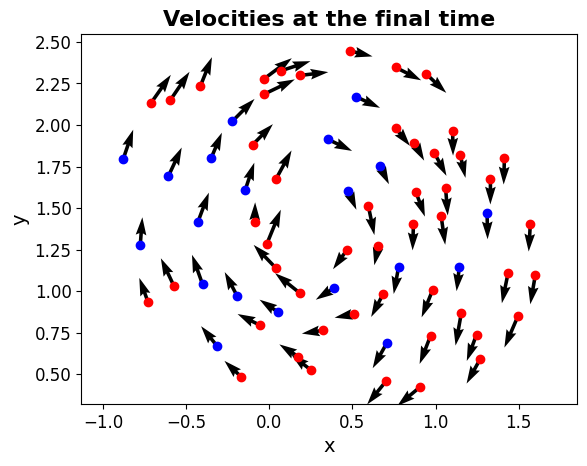

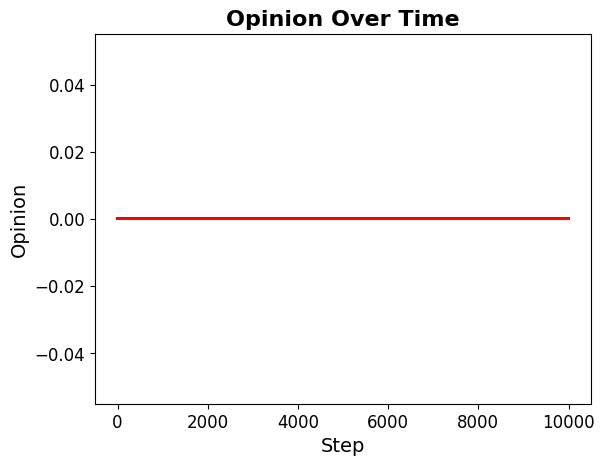

In [35]:
# PLOT: final velocity configuration

plt.figure()
plt.plot(x[-1, :n_l, 0], x[-1, :n_l, 1], 'o', c='b')
plt.plot(x[-1, n_l:n_l+n_f, 0], x[-1, n_l:n_l+n_f, 1], 'o', c='r')
plt.plot(x[-1, n_l+n_f:n, 0], x[-1, n_l+n_f:n, 1], 'o', c='k')
plt.quiver(x[-1, :, 0], x[-1, :, 1], v[-1, :, 0], v[-1, :, 1], color='k')
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(False)
plt.title('Velocities at the final time', fontsize=16, fontweight='bold')
plt.axis('equal')

output_file = os.path.join(output_folder, 'velocity.svg')
plt.savefig(output_file)



# plt.show()


# PLOT: opinion over time

plt.figure()
plt.plot(range(steps), w[:, :n_l], 'b', linewidth=1.5)
plt.plot(range(steps), w[:, n_l:n_l+n_f], 'r', linewidth=1.5)
plt.plot(range(steps), w[:, n_l+n_f:], 'k', linewidth=1.5)
plt.xlabel('Step', fontsize=14)
plt.ylabel('Opinion', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Opinion Over Time', fontsize=16, fontweight='bold')
plt.grid(False)

output_file = os.path.join(output_folder, 'opinion.svg')
plt.savefig(output_file)

# plt.show()

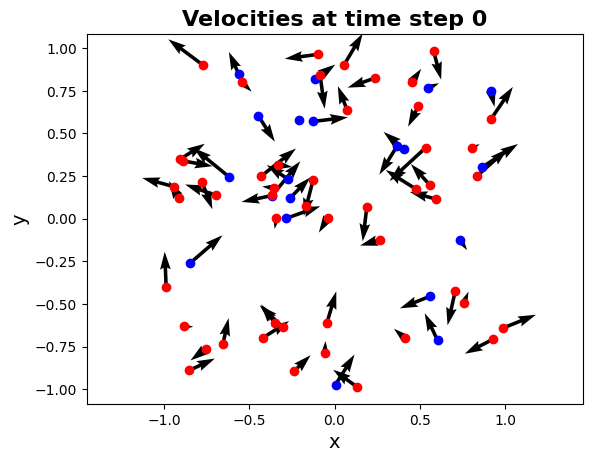

In [26]:
# RECORD: movie

fig, ax = plt.subplots()

def update(i):
    ax.clear()

    ax.plot(x[i, :n_l, 0], x[i, :n_l, 1], 'o', c='b')
    ax.plot(x[i, n_l:n_l+n_f, 0], x[i, n_l:n_l+n_f, 1], 'o', c='r')
    ax.plot(x[i, n_l+n_f:n, 0], x[i, n_l+n_f:n, 1], 'o', c='k')

    ax.quiver(x[i, :, 0], x[i, :, 1], v[i, :, 0], v[i, :, 1], color='k')
    ax.set_xlabel('x', fontsize=14)
    ax.set_ylabel('y', fontsize=14)
    ax.set_title(f'Velocities at time step {i}', fontsize=16, fontweight='bold')
    ax.axis('equal')
    ax.grid(False)

frame_indices = range(0, steps, 10)
ani = animation.FuncAnimation(fig, update, frames=frame_indices)
output_file = os.path.join(output_folder, 'swarm_movie.mp4')
ani.save(output_file, writer='ffmpeg', fps=10)

In [27]:
# # PLOT: velocities over time

# time = np.arange(1, x.shape[0], 1000)  # Time indices corresponding to the 1:1000:end sampling
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# for t in time:
#     ax.scatter(x[t, :, 0], x[t, :, 1], np.full(n, t), c='b', marker='o', edgecolors='b')
# for t in time:
#     ax.quiver(x[t, :, 0], x[t, :, 1], np.full(n, t), v[t, :, 0], v[t, :, 1], np.zeros(n), color='r', length=0.15)
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('step')
# ax.set_title('Velocities Over Time')
# plt.grid(True)

# output_file = os.path.join(output_folder, 'velocities_over_time.svg')
# plt.savefig(output_file)

# plt.show()


# # PLOT: positions over time

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# for t in time:
#     ax.scatter(x[t, :n_l, 0], x[t, :n_l, 1], np.full(n_l, t), c='b', marker='o', edgecolors='b')
#     ax.scatter(x[t, n_l:n_l+n_f, 0], x[t, n_l:n_l+n_f, 1], np.full(n_f, t), c='r', marker='o', edgecolors='r')
#     ax.scatter(x[t, n_l+n_f:n, 0], x[t, n_l+n_f:n, 1], np.full(n_u, t), c='k', marker='o', edgecolors='k')
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('step')
# ax.set_title('Position Over Time')
# plt.grid(True)

# output_file = os.path.join(output_folder, 'positions_over_time.svg')
# plt.savefig(output_file)

# plt.show()


# # PLOT: mean velocities over time

# mean_vx_time = np.mean(v[:, :, 0], axis=1)
# mean_vy_time = np.mean(v[:, :, 1], axis=1)
# time = np.arange(v.shape[0])

# plt.figure()

# plt.subplot(2, 1, 1)
# plt.plot(time, mean_vx_time, 'b-', linewidth=2)
# plt.xlabel('Steps')
# plt.ylabel('Mean V_x')
# plt.title('Mean Velocity Component V_x Over Time')
# plt.grid(True)

# plt.subplot(2, 1, 2)
# plt.plot(time, mean_vy_time, 'r-', linewidth=2)
# plt.xlabel('Steps')
# plt.ylabel('Mean V_y')
# plt.title('Mean Velocity Component V_y Over Time')
# plt.grid(True)

# output_file = os.path.join(output_folder, 'mean_velocities.svg')
# plt.savefig(output_file)

# plt.show()


# # PLOT: mean opinion over time

# mean_opinion = np.mean(w, axis=1)
# plt.figure()
# plt.plot(time, mean_opinion, 'k', linewidth=1.5)
# plt.xlabel('Steps')
# plt.ylabel('Mean Opinion')
# plt.title('Mean Opinion of the Whole Population')
# plt.grid(True)

# output_file = os.path.join(output_folder, 'mean_opinion.svg')
# plt.savefig(output_file)

# plt.show()


# # PLOT: mean velocity magnitude

# mean_velocity_magnitude = np.sqrt(mean_vx_time**2 + mean_vy_time**2)
# plt.figure()
# plt.plot(time, mean_velocity_magnitude, 'k-', linewidth=2)
# plt.xlabel('Steps')
# plt.ylabel('Mean Velocity Magnitude')
# plt.title('Mean Velocity Magnitude Over Time')
# plt.grid(True)

# output_file = os.path.join(output_folder, 'mean_velocity_magnitude.svg')
# plt.savefig(output_file)

# plt.show()